In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

In [1]:
! wget "https://raw.githubusercontent.com/AI4Finance-Foundation/FinRL/refs/heads/master/requirements.txt"
! sudo apt-get install swig
! pip install box2d-py
! pip install -r requirements.txt
! pip install finrl yfinance stable_baselines3

--2025-02-02 10:57:55--  https://raw.githubusercontent.com/AI4Finance-Foundation/FinRL/refs/heads/master/requirements.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 729 [text/plain]
Saving to: ‘requirements.txt’

requirements.txt    100%[===================>]     729  --.-KB/s    in 0s      

2025-02-02 10:57:56 (30.4 MB/s) - ‘requirements.txt’ saved [729/729]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 62 not upgraded.
Need to get 1,116 kB of archives.
After 

In [81]:
import yfinance as yf
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

ticker = "GOOGL"
benchmark_ticker = "^GSPC"
start_date = "2015-01-01"
end_date = "2025-01-01"

df_stock = YahooDownloader(start_date=start_date, end_date=end_date, ticker_list=[ticker]).fetch_data()
df_benchmark = YahooDownloader(start_date=start_date, end_date=end_date, ticker_list=[benchmark_ticker]).fetch_data()

df = pd.merge(df_stock, df_benchmark[['date', 'close']], on='date', suffixes=('', '_benchmark'))
df['date'] = pd.to_datetime(df['date'])

df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (2516, 8)
Shape of DataFrame:  (2516, 8)


,date,open,high,low,close,volume,tic,day,close_benchmark
0,2015-01-02,26.381865,26.477501,26.790001,26.629999,26480000,GOOGL,4,2058.899902
1,2015-01-05,25.879185,25.973000,26.399500,26.357500,41182000,GOOGL,0,2054.439941
2,2015-01-06,25.240503,25.332001,26.060499,26.025000,54456000,GOOGL,1,2022.150024
3,2015-01-07,25.166271,25.257500,25.574499,25.547501,46918000,GOOGL,2,2005.550049
4,2015-01-08,25.253954,25.345501,25.375000,25.075500,73054000,GOOGL,3,2030.609985
...,...,...,...,...,...,...,...,...,...
2511,2024-12-24,196.110001,196.110001,196.110001,194.839996,10403300,GOOGL,1,5984.629883
2512,2024-12-26,195.600006,195.600006,196.750000,195.149994,12046600,GOOGL,3,6024.970215
2513,2024-12-27,192.759995,192.759995,195.320007,194.949997,18891400,GOOGL,4,6006.169922
2514,2024-12-30,191.240005,191.240005,192.550003,189.800003,14264700,GOOGL,0,5920.669922


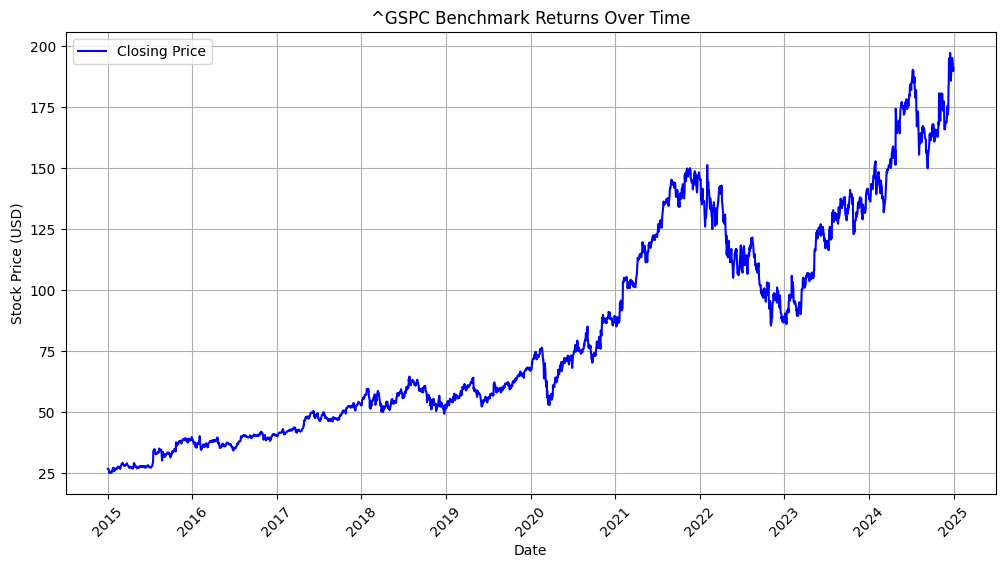

In [79]:
# Plot stock closing price over time
%matplotlib inline
plt.figure(figsize=(12, 6))
sns.lineplot(x=df["date"], y=df["close"], label="Closing Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title(f"{benchmark_ticker} Benchmark Returns Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


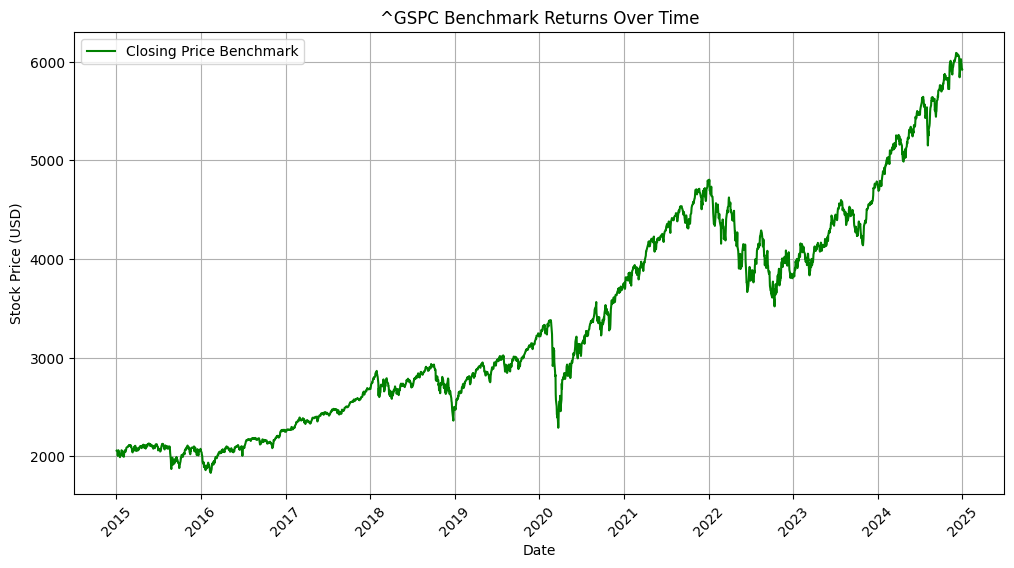

In [78]:
# Plot benchmark data over time
%matplotlib inline
plt.figure(figsize=(12, 6))
sns.lineplot(x=df["date"], y=df["close_benchmark"], label="Closing Price Benchmark", color="green")
plt.xlabel("Date")
plt.ylabel("Stock Price (USD)")
plt.title(f"{benchmark_ticker} Benchmark Returns Over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [82]:
from finrl.config import INDICATORS
from finrl.meta.preprocessor.preprocessors import FeatureEngineer

fe = FeatureEngineer(
    use_technical_indicator=True, 
    tech_indicator_list=INDICATORS,
    use_turbulence=True
)
df = fe.preprocess_data(df)

df

Successfully added technical indicators
Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,close_benchmark,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2015-01-02,26.381865,26.477501,26.790001,26.629999,26480000,GOOGL,4,2058.899902,0.000000,26.879122,26.108378,0.000000,-66.666667,100.000000,26.629999,26.629999,0.000000
1,2015-01-05,25.879185,25.973000,26.399500,26.357500,41182000,GOOGL,0,2054.439941,-0.006114,26.879122,26.108378,0.000000,-66.666667,100.000000,26.493750,26.493750,0.000000
2,2015-01-06,25.240503,25.332001,26.060499,26.025000,54456000,GOOGL,1,2022.150024,-0.018101,26.943490,25.731509,0.000000,-100.000000,100.000000,26.337500,26.337500,0.000000
3,2015-01-07,25.166271,25.257500,25.574499,25.547501,46918000,GOOGL,2,2005.550049,-0.040349,27.072156,25.207844,0.000000,-95.317939,100.000000,26.140000,26.140000,0.000000
4,2015-01-08,25.253954,25.345501,25.375000,25.075500,73054000,GOOGL,3,2030.609985,-0.070371,27.175384,24.678816,0.000000,-92.239824,100.000000,25.927100,25.927100,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2511,2024-12-24,196.110001,196.110001,196.110001,194.839996,10403300,GOOGL,1,5984.629883,5.806758,204.312874,159.914126,60.466405,111.505752,27.764547,179.496000,173.663333,0.263003
2512,2024-12-26,195.600006,195.600006,196.750000,195.149994,12046600,GOOGL,3,6024.970215,5.880267,205.317387,161.661613,60.605580,102.493853,27.764547,180.007000,174.120999,0.000033
2513,2024-12-27,192.759995,192.759995,195.320007,194.949997,18891400,GOOGL,4,6006.169922,5.854894,206.066574,163.507425,60.463519,84.752061,25.332129,180.489999,174.596499,0.016076
2514,2024-12-30,191.240005,191.240005,192.550003,189.800003,14264700,GOOGL,0,5920.669922,5.357467,205.789141,165.914858,56.910013,59.797508,20.726383,180.874000,175.019666,2.020196


In [86]:
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

class CustomStockTradingEnv(StockTradingEnv):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reward_function = None

    def set_reward_function(self, reward_function):
        self.reward_function = reward_function

    def step(self, actions):
        next_state, reward, terminal, truncated, info = super().step(actions)

        if self.reward_function is not None:
            reward = self.reward_function(self, actions, next_state, reward, terminal, truncated, info)
        
        return next_state, reward, terminal, truncated, info

print("Loaded class CustomStockTradingEnv")

Loaded class CustomStockTradingEnv


In [87]:
reward_logging = False

def sample_custom_reward(self, actions, next_state, reward, terminal, truncated, info):    
    # Convert memory to DataFrame
    df_total_value = pd.DataFrame(self.asset_memory, columns=["account_value"])
    df_total_value["date"] = self.date_memory
    df_total_value["daily_return"] = df_total_value["account_value"].pct_change(1)

    # Compute Sharpe Ratio
    sharpe = None
    if df_total_value["daily_return"].std() != 0:
        sharpe = (252**0.5) * df_total_value["daily_return"].mean() / df_total_value["daily_return"].std()

    if sharpe is None or np.isnan(sharpe):
        sharpe = 0

    # Compute Sortino Ratio
    downside_returns = df_total_value["daily_return"][df_total_value["daily_return"] < 0]
    downside_std = downside_returns.std(ddof=1)  # Downside deviation

    sortino = None
    if downside_std and not np.isnan(downside_std):  # Avoid division errors
        sortino = (252**0.5) * df_total_value["daily_return"].mean() / downside_std

    if sortino is None or np.isnan(sortino):
        sortino = 0

    # Softplus transformation
    sharpe = np.log1p(np.exp(sharpe))  
    sortino = np.log1p(np.exp(sharpe))

    # Compute final reward
    total_reward = sharpe + sortino

    # Log the required data
    if reward_logging:
        print(f"Sharpe Ratio: {sharpe}")
        print(f"Sortino Ratio: {sortino}")
        print(f"Total Reward: {total_reward}")
        print("-----------------------------")

    return total_reward

print("Loaded custom reward function")

Loaded custom reward function


In [106]:
indicators = ["volume",	"macd", "boll_ub", "boll_lb", "rsi_30", "cci_30", "dx_30", "close_30_sma", "close_60_sma", "turbulence"]
turbulence_thresold=100

stock_dim = len(df["tic"].unique())
max_price = df['close'].max()
initial_amount = 10000
hmax = int(initial_amount / max_price)

env = CustomStockTradingEnv(
    df=df, 
    stock_dim=stock_dim, 
    hmax=hmax,
    initial_amount=initial_amount,
    num_stock_shares=[0], 

    # Transaction Cost
    buy_cost_pct=[0.001],
    sell_cost_pct=[0.001],

    # Turbulence Thresold
    turbulence_threshold=turbulence_thresold,
    
    reward_scaling=1e-4,
    tech_indicator_list=indicators,

    # State Space: Portfolio Value + Holdings + Tech Indicators
    state_space= 1 + 2 * stock_dim  + len(indicators) * stock_dim,

    # Action Space
    action_space=stock_dim,
)

env

In [92]:
# Testing the enviroment and set custom reward function
env.reset()
reward_logging = True
env.set_reward_function(sample_custom_reward)

env.step(np.array([5]))
env.step(np.array([-5]))
env.step(np.array([0]))
env.step(np.array([0]))
env.step(np.array([0]))
reward_logging = False

Sharpe Ratio: 0.6931471805599453
Sortino Ratio: 1.0986122886681096
Total Reward: 1.791759469228055
-----------------------------
Sharpe Ratio: 1.4967509569109045e-06
Sortino Ratio: 0.6931479289357038
Total Reward: 0.6931494256866607
-----------------------------
Sharpe Ratio: 3.0168202602393687e-05
Sortino Ratio: 0.6931622647750115
Total Reward: 0.6931924329776139
-----------------------------
Sharpe Ratio: 0.00014018172529275328
Sortino Ratio: 0.6932172738789563
Total Reward: 0.693357455604249
-----------------------------
Sharpe Ratio: 0.0003801953599329528
Sortino Ratio: 0.6933372963084756
Total Reward: 0.6937174916684086
-----------------------------


In [93]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import warnings

warnings.filterwarnings("ignore")

env.reset()
vec_env = make_vec_env(lambda: env, n_envs=1)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=100000) 

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 141  |
|    iterations      | 1    |
|    time_elapsed    | 14   |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.52e+03     |
|    ep_rew_mean          | 6.6e+03      |
| time/                   |              |
|    fps                  | 130          |
|    iterations           | 2            |
|    time_elapsed         | 31           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0032220958 |
|    clip_fraction        | 0.0129       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0            |
|    learning_rate        | 0.0003       |
|    loss                 | 526          |
|    n_updates            | 10           |

In [110]:
obs = vec_env.reset()
vec_env.envs[0].unwrapped.episode = 0 # Prints episode info

portfolio_values = []
timesteps = []
i = 0

while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = vec_env.step(action)

    if done[0]:
        break

    portfolio_value = vec_env.envs[0].unwrapped.asset_memory[-1]
    portfolio_values.append(portfolio_value)
    timesteps.append(i)
    i += 1

day: 2515, episode: 0
begin_total_asset: 10000.00
end_total_asset: 74339.80
total_reward: 64339.80
total_cost: 9.98
total_trades: 2515
Sharpe: 0.845


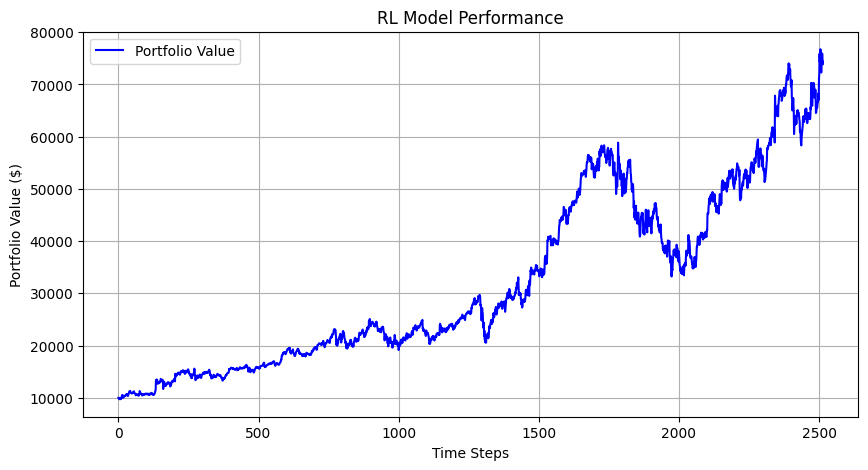

In [101]:
plt.figure(figsize=(10, 5))
plt.plot(timesteps, portfolio_values, label="Portfolio Value", color='blue')
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value ($)")
plt.title("RL Model Performance")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model.save(input())